## **Erick Garcia, Vikram Saini, Aneesh Kapoor**

Data 602 Final project. Comparison of K-means clustering to DBSCAN and MLP on COVID-19 dataset. 

To Run this Notebook, you need to mount your gdrive by authenticating google account that will work with colab and create a folder in your My Drive home directory called Data602Project.


copy contents from this reference folder into your Data602Project folder.
https://drive.google.com/open?id=1H8ZwP2IB5N3DtsWViA5LutvWK-dT6CGx

# COVID-19 Literature Clustering

## Primary Reference
```
@inproceedings{COVID-19 Literature Clustering,
	author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
	title = {COVID-19 Literature Clustering},
	year = {2020},
	month = {April},
	location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
	note={Malware Research Group},
	url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
}
```
[Citation](https://www.kaggle.com/maksimeren/covid-19-literature-clustering)

### Let's take a look at word count in the papers

In [0]:
#Mounting colab notebook to Google Drive with all of the relevent files.
# Importing relavent libraires 
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load in the Covid.csv file from your google drive
df = pd.read_csv('/content/drive/My Drive/Data602Project/covid.csv')

count     36737.000000
mean       4470.407845
std        4903.024837
min           3.000000
25%        2351.000000
50%        3626.000000
75%        5401.000000
max      232431.000000
Name: body_word_count, dtype: float64

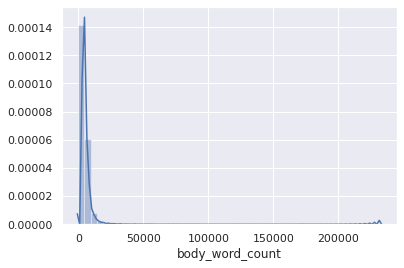

In [0]:
#Checking number of words in each file
#Average of 4470 words per document. Largest document contained 232431 words. 
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count    36737.000000
mean      1387.817486
std        920.646315
min          3.000000
25%        898.000000
50%       1235.000000
75%       1670.000000
max      30523.000000
Name: body_unique_words, dtype: float64

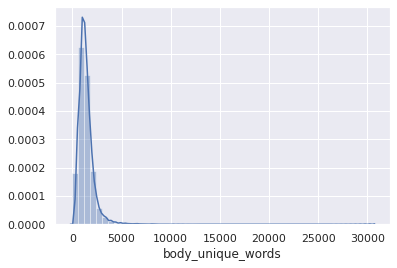

In [0]:
#Unique words in the text of each article. Average of 1387 unique words per article. 
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 4500 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [0]:
# Converting the files into readble vectors. Allows the algorithm to process the files much faster.  
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [0]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(36737, 4096)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [0]:
# Importing K means and applying PCA reduction to the data. 
from sklearn.cluster import KMeans
from numpy import genfromtxt
X_embedded = genfromtxt('/content/drive/My Drive/Data602Project/tsne.csv', delimiter=',')
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(36737, 2503)

[source](https://en.wikipedia.org/wiki/K-means_clustering)

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [0]:
# 20 Clusters proved to be the optimal number for K.
# We did not change the parameters originally used for K means
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

Run DBSCAN

Density Based Spatial Clustering of Applications with Noise. Alternitive clustering technique that can be used to tackle this problem. The required paramaters are epsilon and minimum samples. 

[Citation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [0]:
# Importing DBSCAN. Comparing the results from K-means to results from DBSCAN. 
#Using .7 for epsilon value and 15 for minimum number of samples. 
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=15, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
y_db_pred = db.fit_predict(X_reduced)

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

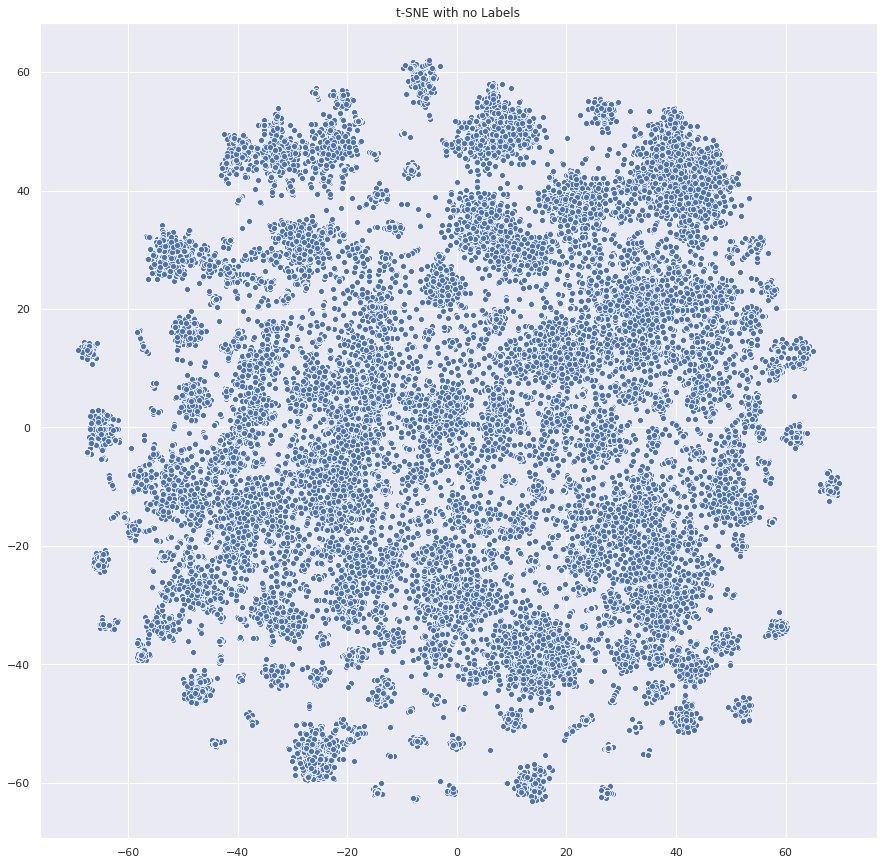

In [0]:
#Plot after running TSNE on K-Means. No labels applied therefore, it is diffult to idenify the individual clusters. 
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

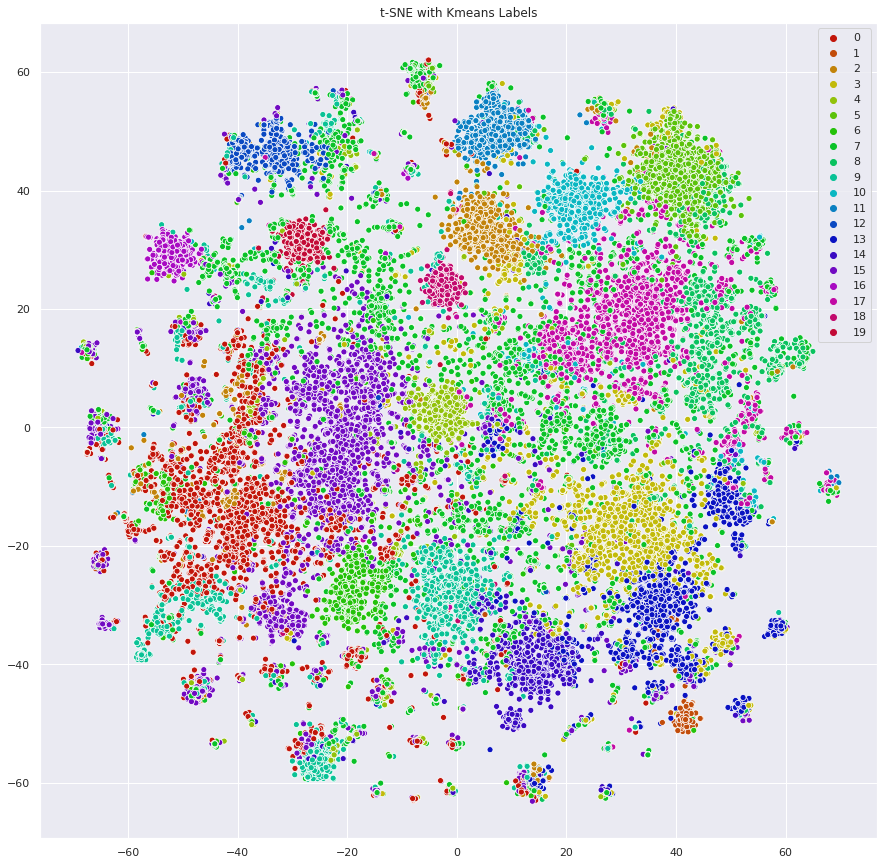

In [0]:
#Similar to the above plot but, includes the unique labels. 20 Unique labels meaning 20 differnt clusters. 
# Much each to read and idenitfy clusters thean the previous plot
#K-means preforms well on this data. 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.show()

In [0]:
print(len(np.unique(y_db_pred)))

101


PLOT LABELS FROM DBSCAN

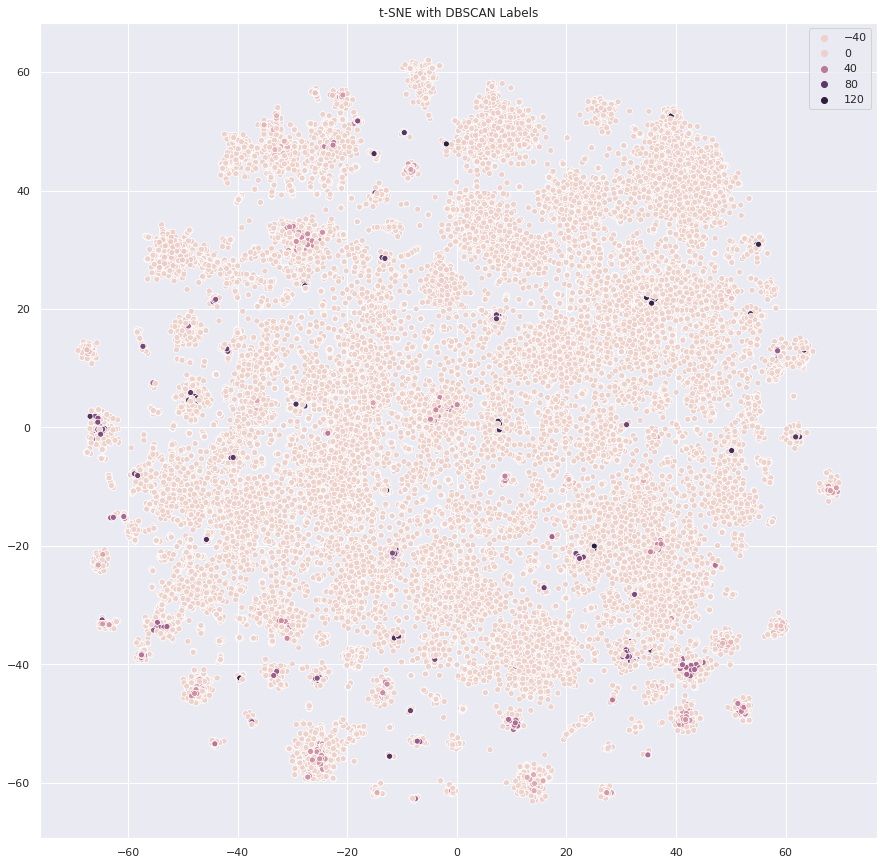

In [0]:
#Plot that results from using DBSCAN. Compared to K-means it did not preform very well
#Created 120 clusters. Using diffrnent eps values did not help much. 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(int(len(np.unique(y_db_pred))), l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_db_pred, legend='brief')
plt.title('t-SNE with DBSCAN Labels')
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

DBSCAN did not prove to be a viable alternitve for this dataset. Since the eps value is a fixed value for distance between points it can be difficult to idenify the optimal value. Also, it may be that DBSCAN should not be used on data that has gone through PCA and TSNE. 

# Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to. 

In [0]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

Let's split the data into train/test sets

In [0]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 29389
X_test size: 7348 



Now let's create a Stochastic Gradient Descent classifier 

**Precision** is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions<br>
**Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.<br>
**F1 score**  is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

#### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)

In [0]:
#Accuracy for K-Means clustering. 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_predtrain = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_predtrain)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  91.459 %
     Precision:  92.775 %
        Recall:  91.781 %
      F1 score:  92.196 %


To test for overfitting, let's see how the model generalizes over the test set

In [0]:
# cross validation predictions
sgd_predtest = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_predtest)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  89.045 %
     Precision:  92.043 %
        Recall:  89.616 %
      F1 score:  90.737 %


Now let's see how the model can generalize across the whole dataset. 

In [0]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 92.060 %


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


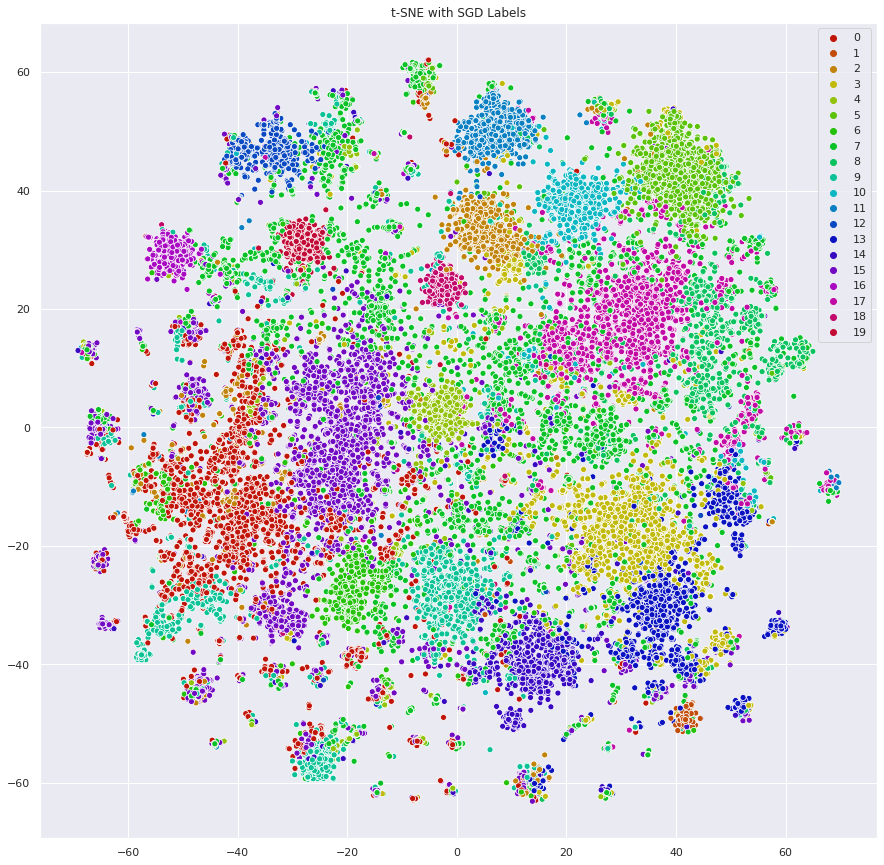

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sgd_predall = cross_val_predict(sgd_clf, X.toarray(), y_pred, cv=10, n_jobs=-1)
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)
sgd_clf, X.toarray(), y_pred
# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=sgd_predall, legend='full', palette=palette)
plt.title('t-SNE with SGD Labels')
plt.show()

# Multi Layer Perceptron

[Citation](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch12/ch12.ipynb)

In [0]:
#Loading MLP Code from Raschka Github 
from urllib.request import urlretrieve
url="https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py"
urlretrieve(url, 'neuralnet.py')

('neuralnet.py', <http.client.HTTPMessage at 0x7fcf654bd438>)

30/30 | Cost: 37590.93 | Train/Valid Acc.: 85.75%/85.21% 

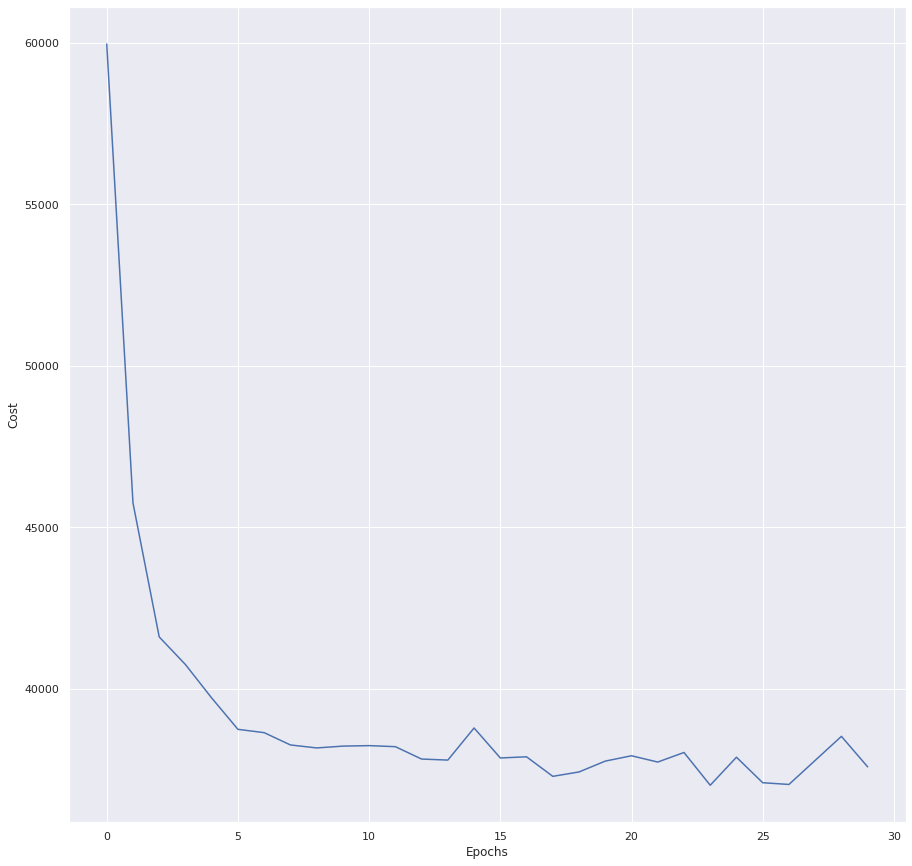

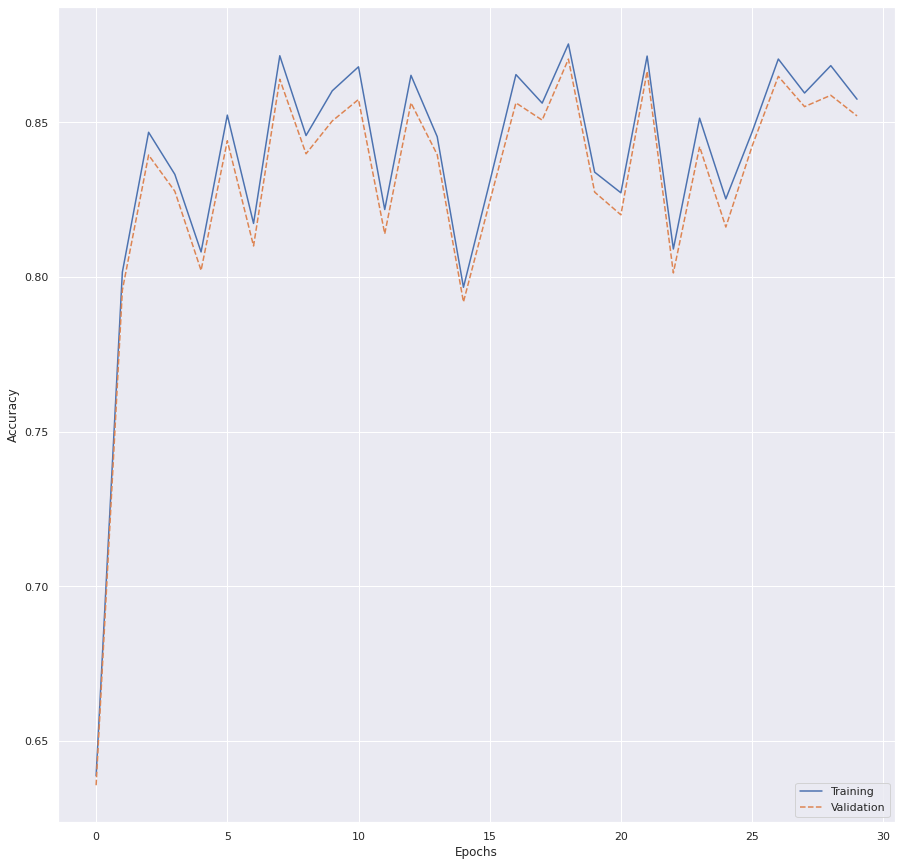

MLP:  :

Accuracy Score:  85.746 %
     Precision:  88.221 %
        Recall:  72.235 %
      F1 score:  77.048 %
MLP:  :

Accuracy Score:  85.207 %
     Precision:  87.650 %
        Recall:  71.953 %
      F1 score:  76.459 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#Running MLP to test how it classfies the COVID-19 data compared to K-means and DBSCAN. 
from neuralnet import NeuralNetMLP
import matplotlib.pyplot as plt
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)
M = NeuralNetMLP(n_hidden=10, epochs = 30, eta=.05, minibatch_size=10, shuffle=True, l2=0.01)
M.fit(X_train,y_train, X_test, y_test)
plt.plot(range(M.epochs), M.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()
plt.plot(range(M.epochs), M.eval_['train_acc'], 
         label='Training')
plt.plot(range(M.epochs), M.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()
y_train_pred = M.predict(X_train)
y_test_pred = M.predict(X_test)
y_mlp_pred = M.predict(X.toarray())
#acc = (np.sum(y_test == y_test_pred)
#       .astype(np.float) / X_test.shape[0])
#print('Test accuracy: %.2f%%' % (acc * 100))
classification_report("MLP: ", y_train, y_train_pred)
classification_report("MLP: ", y_test, y_test_pred)

19


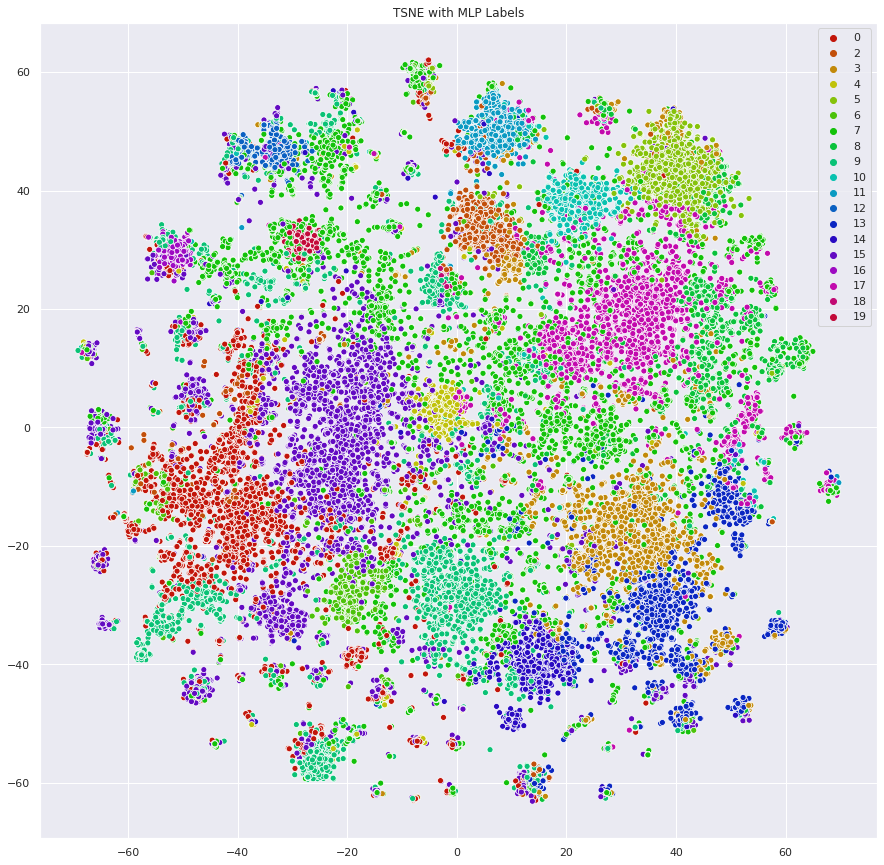

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# print number of unique values in prediction
print(len(np.unique(y_mlp_pred)))
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(19, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_mlp_pred, legend='full', palette=palette)
plt.title('TSNE with MLP Labels')
plt.show()

# Conclusion
In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar theme is grouped together. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters. Both the clusters and keywords are found through unsupervised learning models and can be useful in revealing patterns that humans may not have even thought about. In no part of this project did we have to manually organize the papers: the results are due to latent connections in the data. 
 
K-means (represented by colors) and t-SNE (represented by points) were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. This may mean that k-means and t-SNE can find different similarities to group the papers by. In these conditions, our approach performs quite well.

As this is an unsupervised learning problem, the evaluation of our work was not an exact science. First, the plot was examined to assert that clusters were actually being formed. After being convinced of this, we examined the titles/abstracts of some of the papers in different clusters. For the most part, similar research areas were clustered. Our last evaluation method was classification. By training a classification model with the k-means labels and then testing it on a separate subset of the data, we could see that the clustering was not completely arbitrary as the classifier performed well. 

Our manual inspection of the documents was quite limited, as neither of the authors are qualified to assess the meaning of the literature. Even so, it was apparent that articles on key topics could be easily found in close proximity to each other. For example, searching for 'mask' can reveal a sub cluster of papers that evaluate the efficacy of masks.  We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner.


<br>
<br>
<br>

#Project Summary

The purpose of our project was to better understand the cluster analysis conducted by the original authors on the COVID-19 dataset and potentially improve on the original idea. To do so, we looked to implement different machine learning algorithms and test their effectiveness on the dataset. After using PCA and TSNE to reduce the authors used K-Means clustering to create 20 unique clusters of similar datapoints with a high level of accuracy. First, we decided to implement a Multi-Layer Perceptron (MLP) thinking that it would perform better on this dataset. The MLP successfully classified the dimensionality reduced data. However, the accuracy rate was slightly lower than the K-means clustering. Also, we realized that comparing MLP to K-means is not a fair comparison due to the fact that MLP is a supervised technique and K-means in unsupervised. Next, we attempted to use DBSCAN to cluster the data instead of K-means. We used grid search to identify the optimal epsilon value and other hyperparameters needed for DBSCAN. Using the parameters from the grid search, we successfully ran DBSCAN. However, we found that DBSCAN was creating to many unique clusters when compared to K-means. Selecting the epsilon value for DBSCAN can be difficult as it is a fixed length between each data point. In the end, we were unable to find a better way to cluster this dataset. The analysis supported the conclusion that K-means clustering was the optimal algorithm for this data set.

##Improvments from Original Project


*   Greatly improved runtime by mounting Google drive rather than uploading individual files.  
*   Testing alternitive techniques such as, DBSCAN and MLP to compare resutls.
*   Added additional plots for the diffrent algorithms. 








**Some areas we thought were great:** (pros)
- The tool is saved as an html file. It can be downloaded and used locally/offline.
- It is portable/mobile, easily deployable, and failover safe; the risk of denial of service in the case of emergencies such as the loss of network connection is mitigated
- Dimensionality reduction allows for the whole dataset to be easily accessible. The papers are all up on the plot and can be quickly examined by hovering over them. If the abstract seems interesting, the user can click on the point to bring up a text box with more information that will contain a link to the full paper
- Patterns in the data found through clustering/dimensionality reduction may not be readily apparent to researchers. These unsupervised techniques can show humans hidden connnections in the literature
- If the topics/clusters are not narrow enough for the user, a search for a key term that will only bring up papers that contain the search term. Search can be performed inside of a selected cluster or the entire dataset if preferred. This increases the flexibility of how patterns can be discovered.
- A surface level examination of the plot showed some very interesting organization of the data. For example, one subcluster consisted of papers that tried to determine the efficacy of masks in preventing the spread of COVID-19.
- Once the models are trained, the results can be generated in constant time.
- This work can be easily replicated and modified as needed, serving as a foundation for future projects.

<br>

**Future thoughts to consider:** (cons)
- Possible false positives, difficult to draw an exact line between subjects
- K-means and t-SNE are unsupervised approaches that will not necessarily group instances in a predictable way. Due to their unsupervised nature, there is no 'right answer' for how the papers should be clustered. This could be difficult to debug if problems arise.
- Loss of foreign language papers. This leads to the loss of experience from different geographic locations on dealing with COVID-19
- The algorithms used in this notebook are stochastic so the results may vary depending on the random state. In this notebook all of the algorithms are set to random state 42 (the meaning of life) to ensure reproducible results
- Long run time to train models on large dataset of literature

# Citation/Sources

Kaggle Submission: [COVID-19 Literature Clustering | Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering#Unsupervised-Learning:-Clustering-with-K-Means)
 
 ```
@inproceedings{Raff2020,
	author = {Raff, Edward and Nicholas, Charles and McLean, Mark},
	booktitle = {The Thirty-Fourth AAAI Conference on Artificial Intelligence},
	title = {{A New Burrows Wheeler Transform Markov Distance}},
	url = {http://arxiv.org/abs/1912.13046},
	year = {2020},
}
```
```
@misc{Kaggle,
	author = {Kaggle},
	title = {COVID-19 Open Research Dataset Challenge (CORD-19)},
	year = {2020},
	month = {March},
	note = {Allen Institute for AI in partnership with the Chan Zuckerberg Initiative, Georgetown University’s Center for   Security and Emerging Technology, Microsoft Research, and the National Library of Medicine - National Institutes of Health, in coordination with The White House Office of Science and Technology Policy.},
	howpublished = {\url{https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge}}
}
```
```
@inproceedings{Shakespeare,
	author = {Nicholas, Charles},
	title = {Mr. Shakespeare, Meet Mr. Tucker},
	booktitle = {High Performance Computing and Data Analytics Workshop},
	year = {2019},
	month = {September},
	location = { Linthicum Heights, MD, USA},
}
```
```
@inproceedings{raff_lzjd_2017,
	author = {Raff, Edward and Nicholas, Charles},
	title = {An Alternative to NCD for Large Sequences, Lempel-Ziv Jaccard Distance},
	booktitle = {Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
	series = {KDD '17},
	year = {2017},
	isbn = {978-1-4503-4887-4},
	location = {Halifax, NS, Canada},
	pages = {1007--1015},
	numpages = {9},
	url = {http://doi.acm.org/10.1145/3097983.3098111},
	doi = {10.1145/3097983.3098111},
	acmid = {3098111},
	publisher = {ACM},
	address = {New York, NY, USA},
	keywords = {cyber security, jaccard similarity, lempel-ziv, malware classification, normalized compression distance},
}
```
```
@inproceedings{ML_Book,
    author = {Aurélien Geron},
    title = {Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow},
    pages = {91, 233},
    series = {2},
    year = {2019},
    isbn = {978-1-492-03264-9},
    publisher = {O'Reilly},
    copyright = {Kiwisoft S.A.S},
}
```
	author = {Raschka Sebastian, Mirjalili Vahid},
	booktitle = {Python Machine Learning},
	title = {{Machine Learning and Deep Learing with Python, scikit-learn and Tensor Flow 2},
	year = {2019},
}

<br>
<br>